In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )
x

tensor([[[-0.7270, -0.8947, -2.7210,  ...,  0.5598,  1.1343,  1.3580],
         [ 0.1639,  0.6001, -0.9782,  ...,  1.7738,  1.0832,  0.8257],
         [-0.9060,  0.2155, -0.0517,  ..., -0.9455, -0.0815,  0.4568],
         [ 0.3335, -1.1422,  0.6800,  ...,  0.2278,  0.2498, -0.2644]]])

In [22]:
#4 tokens
#Each token contains 512 features or embedding dim
x.size()

torch.Size([1, 4, 512])

In [23]:
qkv_layer = nn.Linear(input_dim , 3 * d_model)
qkv = qkv_layer(x)
qkv.shape


torch.Size([1, 4, 1536])

In [24]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)
qkv.shape

torch.Size([1, 4, 8, 192])

In [25]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape
#4D tensor
#in 1st head, there are 4 tokens
#for each token,192 dim


torch.Size([1, 8, 4, 192])

In [28]:
#Split a tensor along the last dimension into three equal parts
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [30]:
d_k = q.size()[-1]
d_k

64

In [32]:
l=k.transpose(-2,-1) #swap last 2 dimensions
print(l.size())

torch.Size([1, 8, 64, 4])


In [33]:
import math
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [35]:
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask.shape

torch.Size([1, 8, 4, 4])

In [37]:
#1st head #1st batch
mask[0][0]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [38]:
scaled += mask

In [39]:
attention = F.softmax(scaled, dim=-1)
attention.shape


torch.Size([1, 8, 4, 4])

In [40]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6233, 0.3767, 0.0000, 0.0000],
        [0.2141, 0.3736, 0.4123, 0.0000],
        [0.2816, 0.2397, 0.2470, 0.2317]], grad_fn=<SelectBackward0>)

In [41]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

In [42]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [46]:
print(values[0])
print(values[0].shape)

tensor([[ 0.3392,  0.8506,  0.7894,  ...,  0.1253, -0.3526,  0.0862],
        [ 0.9196,  1.0252,  0.5046,  ...,  0.3081,  0.0313,  0.1444],
        [-0.1941, -0.6401,  0.7461,  ..., -0.4148, -0.2973, -0.4269],
        [ 1.0391,  0.1078, -0.2812,  ..., -0.1044,  0.1781,  0.3368]],
       grad_fn=<SelectBackward0>)
torch.Size([4, 512])


In [47]:
#Single layer neural network
#no of neurons=512
#shape of weight matrix=512*512
#shape of bias=512
linear_layer = nn.Linear(d_model, d_model)
out = linear_layer(values)
out.shape

torch.Size([1, 4, 512])

**Application of nn.Linear with dummy example**

In [15]:
import torch
import torch.nn as nn

input_dim = 12
d_model = 12


qkv = nn.Linear(input_dim, 3 * d_model)

# Dummy input tensor with batch size 1,seq_length=2 and input_dim 3

#input_tensor = torch.tensor([[1.0, 2.0, 3.0],
                             #[4.0, 5.0, 6.0]])

input_tensor = torch.randn( (1, 4, 12) )

output_tensor = qkv(input_tensor)

print("Input Tensor:\n", input_tensor)
print("Output Tensor:\n", output_tensor)
print(output_tensor.size())


Input Tensor:
 tensor([[[ 0.8022, -0.1884, -0.8931, -2.0933,  0.0666,  0.6732, -1.3120,
          -0.3557, -1.6046, -0.4721, -0.2258, -1.6859],
         [-1.0086,  0.9847, -0.6876, -0.4136, -0.5413,  0.6842,  2.0338,
           0.2225, -1.5264,  0.1283, -0.2348, -0.0654],
         [-0.4149,  0.5119, -0.6645,  1.4736,  0.4247,  1.5432, -0.2592,
           1.3171,  0.7211, -0.5402, -1.3119,  0.5879],
         [-1.0680,  1.6208, -0.2315, -0.1335,  0.3222, -0.8278,  1.5371,
          -0.2229, -0.5709, -0.4565,  1.1787,  0.9265]]])
Output Tensor:
 tensor([[[ 1.5539e+00,  1.0573e-02, -8.9102e-01, -1.5485e-02,  4.6146e-01,
          -2.3809e-01,  8.4603e-01, -7.8856e-01,  1.6504e+00, -5.4058e-01,
           1.2570e-01,  1.9832e-01, -4.8110e-01, -7.9320e-02,  1.6361e-02,
           9.4122e-01, -4.0650e-02, -1.4946e-01, -4.9681e-02, -3.9152e-01,
          -8.1892e-01,  5.4422e-01,  2.0096e-01, -1.8358e+00, -9.5968e-02,
          -3.1845e-01,  1.1246e+00, -7.8228e-01,  6.1943e-01, -1.6563e-01,
 

In [18]:
num_heads = 3
head_dim = 12 // num_heads
output_tensor = output_tensor.reshape(1, 4, num_heads, 3 * head_dim)
output_tensor.shape

torch.Size([1, 4, 3, 12])

In [26]:
output_tensor = output_tensor.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
output_tensor.shape

torch.Size([1, 3, 4, 12])

In [27]:
output_tensor

tensor([[[[ 1.5539e+00,  1.0573e-02, -8.9102e-01, -1.5485e-02,  4.6146e-01,
           -2.3809e-01,  8.4603e-01, -7.8856e-01,  1.6504e+00, -5.4058e-01,
            1.2570e-01,  1.9832e-01],
          [-1.7820e-01,  2.2090e-01, -1.4614e+00,  6.9698e-01, -4.4897e-02,
           -5.2483e-01, -5.1568e-01,  4.0721e-01, -8.7504e-02, -1.1450e+00,
            6.8082e-01, -1.3362e-01],
          [-5.8814e-01, -2.0988e-02, -5.9108e-01, -2.8446e-01,  7.2952e-01,
            4.1693e-01,  3.0688e-01,  1.4667e-01, -5.3120e-01,  1.0709e-02,
           -5.2382e-02, -1.2858e+00],
          [-4.2552e-01,  3.8116e-01, -4.4117e-01,  1.0736e+00, -1.4150e-01,
           -1.0826e+00, -7.8051e-01,  2.7395e-01,  3.0793e-01, -8.0654e-01,
           -1.1095e-02, -6.0150e-02]],

         [[-4.8110e-01, -7.9320e-02,  1.6361e-02,  9.4122e-01, -4.0650e-02,
           -1.4946e-01, -4.9681e-02, -3.9152e-01, -8.1892e-01,  5.4422e-01,
            2.0096e-01, -1.8358e+00],
          [-6.7909e-01, -4.1530e-01,  5.0316e-01

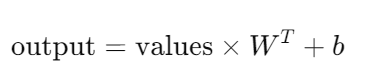

In [29]:
query,key,value=output_tensor.chunk(3, dim=-1)
query.shape, key.shape, value.shape

(torch.Size([1, 3, 4, 4]), torch.Size([1, 3, 4, 4]), torch.Size([1, 3, 4, 4]))

**Modularization**

In [48]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


In [49]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)


x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
